In [1]:
# config
import common.init as init
from singleton_pattern.load_model import get_model
from  singleton_pattern.load_config import get_config,get_non_dnn_method_list
from singleton_pattern.load_dataset_reader import get_train_reader,get_test_reader
from singleton_pattern.load_data_generator import get_train_data_generator,get_test_data_generator
from common.cache import Cache
from common.cuda_info import get_device
from common.cache import CacheType
config_name = 'PhysNet.yaml'
# config_name = 'POS.yaml'
# init
init.run(config_name)

CUDA:
---------------------------
PyTorch supports GPU and currently has 1 CUDA devices available.
The current default CUDA device is: NVIDIA GeForce RTX 3090
---------------------------
Method and DataGenerator Name: PhysNet


In [2]:
config = get_config()
non_dnn_method_list = get_non_dnn_method_list()
model = get_model()
is_need_train = config['method'] not in non_dnn_method_list
# load test dataset
test_reader = get_test_reader()
test_data_generator = get_test_data_generator()
print(f'Test Loader: {test_reader.loader_name}')
test_data = test_reader.load_data()
test_dataloader = test_data_generator.get_tensor_dataloader(test_data)

Test Loader: UBFC_Phys
Root Path:D:\dataset\compression\UBFC-PHYs_1
Start Reading UBFC_Phys Dataset Directory...


Progress:   0%|          | 0/1 [00:00<?, ?it/s]

cache path:cache\TEST\5c685eb5b075d1f4fec4da8f9833b7b982ff932acb5fdc506f51b1c13dfcd9f5
dataset size: 11


In [3]:
train_dataloader = None
# load train dataset
if is_need_train:
    train_reader = get_train_reader()
    print(f'train_reader: {train_reader.loader_name}')
    train_data = train_reader.load_data()
    train_data_generator = get_train_data_generator()
    train_dataloader = train_data_generator.get_tensor_dataloader(train_data)

# if cached and want to second training, set train_twice = True
train_twice = True
# train
if not is_need_train:
    print('non train.')
else:
    from common.train_model import run as run_train
    if train_dataloader is None:
        raise Exception('load train dataloader first')
    if train_twice:
        cache_model = Cache(CacheType.MODEL).read_model()
        model.load_state_dict(cache_model.state_dict())
    run_train(model,train_dataloader,test_dataloader)

train_reader: UBFC_Phys
Root Path:D:\dataset\compression\UBFC-PHYs_1_11
Start Reading UBFC_Phys Dataset Directory...


Progress:   0%|          | 0/11 [00:00<?, ?it/s]

cache path:cache\TRAIN\fe9d4b674f5c86e5c1f1dbf7b73420e300a3c39f37f6340eb6bc69d23e81c0be
Start Generator Data...


Progress:   0%|          | 0/11 [00:00<?, ?it/s]

Processing videos 1 :   0%|          | 0/6326 [00:00<?, ?it/s]

Processing videos 2 :   0%|          | 0/6326 [00:00<?, ?it/s]

Processing videos 3 :   0%|          | 0/6325 [00:00<?, ?it/s]

Processing videos 4 :   0%|          | 0/6326 [00:00<?, ?it/s]

Processing videos 5 :   0%|          | 0/6326 [00:00<?, ?it/s]

Processing videos 6 :   0%|          | 0/6326 [00:00<?, ?it/s]

Processing videos 7 :   0%|          | 0/6326 [00:00<?, ?it/s]

Processing videos 8 :   0%|          | 0/6325 [00:00<?, ?it/s]

Processing videos 9 :   0%|          | 0/6325 [00:00<?, ?it/s]

Processing videos 10 :   0%|          | 0/6325 [00:00<?, ?it/s]

Processing videos 11:   0%|          | 0/6326 [00:00<?, ?it/s]

In [ ]:
# load test model
use_cache_model = False

import matplotlib.pyplot as plt
import numpy as np
if use_cache_model and is_need_train:
    cache_model = Cache(CacheType.MODEL).read_model()
    model.load_state_dict(cache_model.state_dict())
model.eval()
model.to(get_device())
pass

cache path:cache\MODEL\


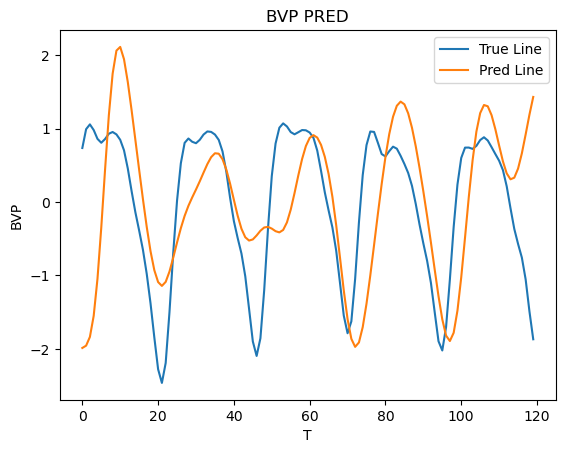

In [ ]:
# output image
i = 0
gpu_device = get_device()
for batch_X, batch_y in test_dataloader:
    index_n = 1
    if i == index_n:
        plt.title("BVP PRED")
        plt.xlabel("T")
        plt.ylabel("BVP")

        batch_X = batch_X.to(gpu_device)
        batch_y = batch_y.to(gpu_device)
        pred = model(batch_X)
        true_data = batch_y.cpu().view(-1).numpy()
        pred_data = pred.cpu().view(-1).numpy()
        true_data = true_data = (true_data - true_data.mean())/true_data.std()
        pred_data = pred_data = (pred_data - pred_data.mean())/pred_data.std()
        plt.plot(true_data, label="True Line")
        plt.plot(pred_data, label="Pred Line")
        plt.legend()
        plt.show()
    if i > index_n:
        break
    i+=1
